In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.grid_search import GridSearchCV

%matplotlib inline

In [43]:
df = pd.read_csv('/Users/dominicdebiaso/Development/datasets/dsc_employee_retention.csv')

# EDA

In [44]:
df.dtypes

employee_id      int64
company_id       int64
dept            object
seniority        int64
salary         float64
join_date       object
quit_date       object
dtype: object

In [45]:
# Changing data types
df['employee_id'] = df.employee_id.astype('object')
df['company_id'] = df.company_id.astype('object')
df['join_date'] = pd.to_datetime(df.join_date, errors='coerce')
df['quit_date'] = pd.to_datetime(df.quit_date, errors='coerce')

In [46]:
df.describe(include='all').fillna('')

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
count,24702,24702,24702,24702,24702,24702,13510
unique,16578,12,6,,,995,664
top,5832,1,customer_service,,,2012-01-03 00:00:00,2015-05-08 00:00:00
freq,5,8486,9180,,,105,111
first,,,,,,2011-01-24 00:00:00,2011-10-13 00:00:00
last,,,,,,2015-12-10 00:00:00,2015-12-09 00:00:00
mean,,,,14.1278,138183,,
std,,,,8.08952,76058.2,,
min,,,,1,17000,,
25%,,,,7,79000,,


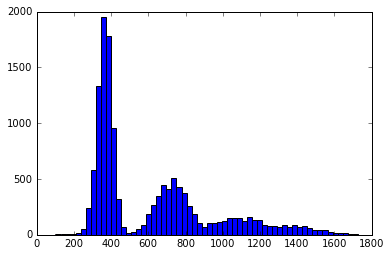

In [47]:
# Get length of employment
length_list = [int(i.days) for i in (df.quit_date - df.join_date).fillna(0)]
length_list = filter(lambda x: x != 0, length_list)
_ = plt.hist(length_list, bins=60)

In [48]:
# Get headcount by date for each company
df_join = df.groupby(['company_id', 'join_date']).size().groupby(level=[0]).cumsum().reset_index().rename(columns={0:'join_count'})
df_quit = df.groupby(['company_id', 'quit_date']).size().groupby(level=[0]).cumsum().reset_index().rename(columns={0:'quit_count'})
df_merge = pd.merge(df_join, df_quit, left_on=['company_id', 'join_date'], right_on=['company_id', 'quit_date'], how='outer')
df_merge.join_count.fillna(0, inplace=True)
df_merge.quit_count.fillna(0, inplace=True)
df_merge['headcount'] = (df_merge.join_count) - (df_merge.quit_count)
df_merge['date'] = df_merge.join_date.fillna(df_merge.quit_date)
df_merge.drop(['join_count', 'quit_count'], axis=1 ,inplace=True)

# ML

In [49]:
# Create a binary class for early quitters
df['length'] = (df.quit_date - df.join_date).fillna(0)
df.loc[(df.length > '0 days') & (df.length <= '396 days'), 'early_quitter'] = 1
df.early_quitter.fillna(0, inplace=True)
df_model = df[['company_id', 'dept', 'seniority', 'salary', 'early_quitter']]
df_model = pd.get_dummies(df_model)

In [50]:
# Minimum number of observations in a node by 30 before attempting split
clf_tree = tree.DecisionTreeClassifier()
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [3],
              'min_samples_split': [20, 30, 40]}
grid = GridSearchCV(clf_tree, param_grid)
grid.fit(df_model.drop('early_quitter', axis=1), df_model.early_quitter)
grid.best_params_

{'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 20}

In [82]:
clf_tree = tree.DecisionTreeClassifier(max_depth=3, min_samples_split=20, class_weight='balanced')
clf_tree.fit(df_model.drop('early_quitter', axis=1), df_model.early_quitter)

importances = clf_tree.feature_importances_
importances = zip(df_model.drop('early_quitter', axis=1).columns, importances)
sorted(importances, key=lambda x: x[1], reverse=True)[:2]

[('salary', 0.98793483144960614), ('seniority', 0.01206516855039387)]

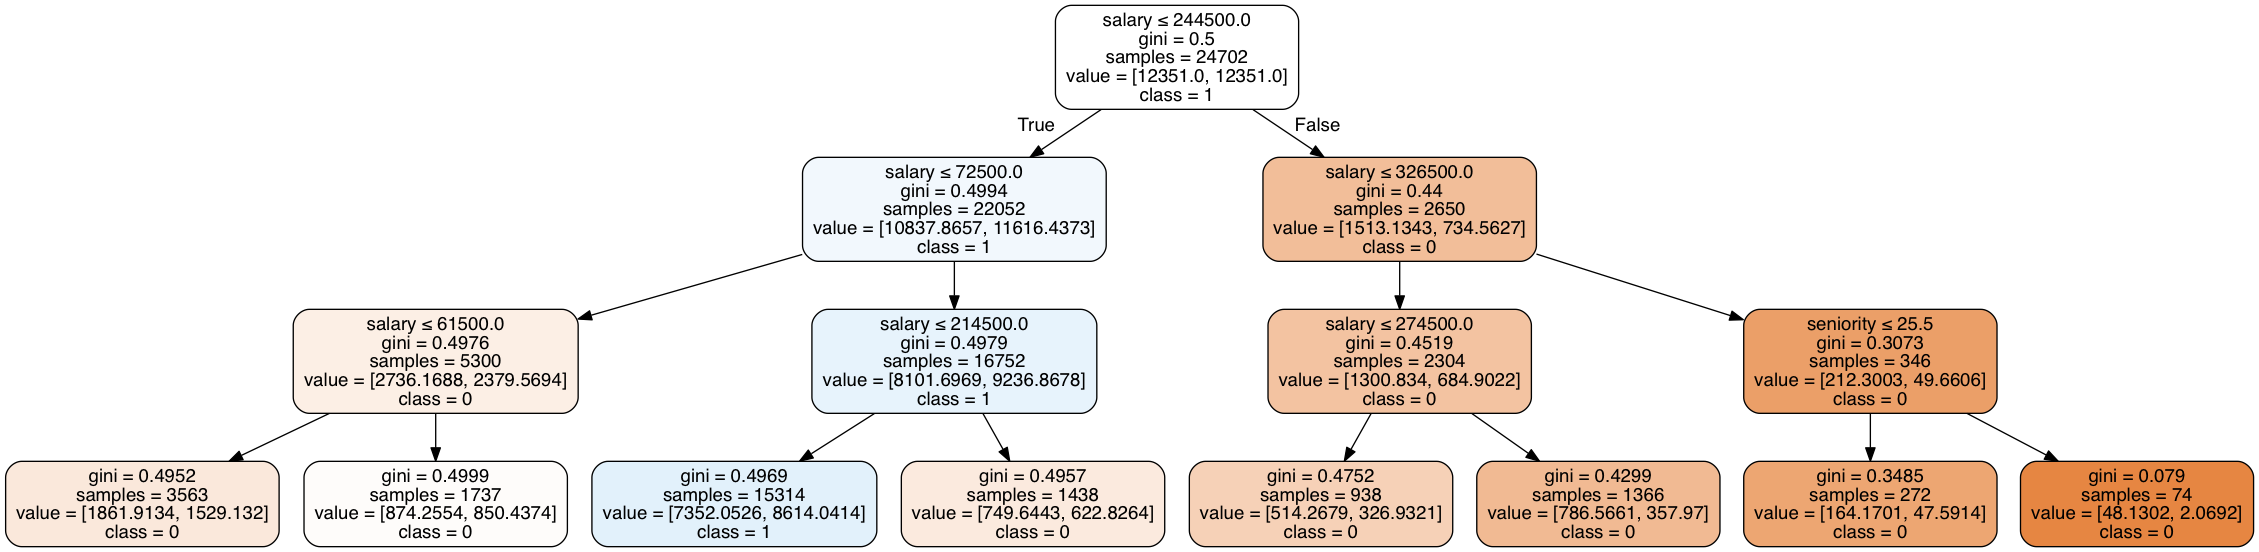

In [83]:
from sklearn.externals.six import StringIO
import pydotplus
from IPython.display import Image
dot_data = StringIO()
tree.export_graphviz(clf_tree, out_file=dot_data, 
                     feature_names=df_model.drop('early_quitter', axis=1).columns, 
                     class_names=['0','1'], 
                     filled=True, rounded=True, 
                     special_characters=True)
graph=pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

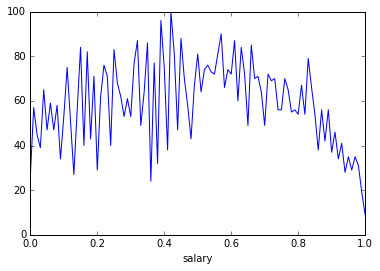

In [90]:
# Proportion of early quitters by salary percentile
df_model[df_model.early_quitter == 1].groupby(df_model.salary.rank(pct=True).round(2)).size().plot(kind='line')